# Keyness: document frequency analysis per theme

In [1]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [2]:
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Set paths and load functions

In [3]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
review_stats_file = '../data/review-stats-clean.tsv.gz'

review_theme_file = '../data/review_work_genre_theme.tsv.gz'
review_impact_terms_file = '../data/review_work_genre-impact_terms.tsv.gz'
review_impact_counts_file = '../data/review_work_genre-impact_counts.tsv.gz'

isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"
isbn_topic_file = '../data/isbn_topic_scores.tsv.gz'

## Read information on ISBN, Topic and Theme

In [4]:
isbn_topic = pd.read_csv(isbn_topic_file, sep='\t', compression='gzip', dtype={'isbn': str})

# Turn the theme string into a Python list object
isbn_topic['themes'] = isbn_topic.themes.str.split(';')
#isbn_topic['themes'] = isbn_topic.themes.apply(ast.literal_eval)

# explode the themes lists so that each theme is column and rows indicate 
# whether an ISBN has been assigned to a theme.
isbn_theme = isbn_topic.explode('themes')[['isbn', 'themes']].set_index('isbn')
isbn_theme = pd.get_dummies(isbn_theme).reset_index().groupby('isbn').sum().reset_index()
isbn_theme

,isbn,themes_behaviours / feelings,themes_city & travel,themes_crime,themes_culture,themes_economy & work,themes_family,themes_geography & setting,themes_history,themes_lifestyle & sport,themes_medicine / health,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_war,themes_wildlife / nature
0,9789020200485,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,9789020201451,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,9789020202106,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,9789020205008,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,9789020205268,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18462,9789493189560,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18463,9789493189584,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,9789493189607,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18465,9789493189669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Combine Work identifier and theme to Topic and Theme information

In [5]:
from impfic_core.map.map_genre import read_genre_file

# read work theme mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)
work_genre = work_genre[work_genre.record_id_type == 'isbn'].rename(columns={'record_id': 'isbn'})
work_genre = work_genre[['work_id', 'isbn', 'nur_genre']]
work_genre.shape

(189038, 3)

In [6]:
# merge and drop the ISBN column, since we need only the work_id to link
# topic and theme to the reviews and impact terms
work_genre_theme = pd.merge(work_genre, isbn_theme, on='isbn').drop('isbn', axis=1)

# the collection has 18,465 books, so there should be 18,465 rows
work_genre_theme.shape

(18465, 21)

In [7]:
# Some insight in the distribution of books over themes
work_genre_theme.nur_genre.value_counts() / len(work_genre_theme)

Literary_fiction      0.298890
Non-fiction           0.284538
Other fiction         0.108042
Suspense              0.092066
Regional_fiction      0.047983
Literary_thriller     0.044571
Children_fiction      0.030219
Romance               0.028703
Young_adult           0.026807
Fantasy_fiction       0.019767
Historical_fiction    0.018413
Name: nur_genre, dtype: float64

In [8]:
theme_cols = [col for col in work_genre_theme.columns if col.startswith('themes_')]
theme_cols

['themes_behaviours / feelings',
 'themes_city & travel',
 'themes_crime',
 'themes_culture',
 'themes_economy & work',
 'themes_family',
 'themes_geography & setting',
 'themes_history',
 'themes_lifestyle & sport',
 'themes_medicine / health',
 'themes_other',
 'themes_politics',
 'themes_reli. / spirit. / phil.',
 'themes_romance & sex',
 'themes_science',
 'themes_society',
 'themes_super., fantasy & sci-fi',
 'themes_war',
 'themes_wildlife / nature']

In [9]:
for theme in theme_cols:
    work_genre_theme[theme] = work_genre_theme[theme].apply(lambda x: 0 if x == 0 else 1)

In [10]:
work_genre_theme.max()

work_id                            impfic-work-9986
nur_genre                               Young_adult
themes_behaviours / feelings                      1
themes_city & travel                              1
themes_crime                                      1
themes_culture                                    1
themes_economy & work                             1
themes_family                                     1
themes_geography & setting                        1
themes_history                                    1
themes_lifestyle & sport                          1
themes_medicine / health                          1
themes_other                                      1
themes_politics                                   1
themes_reli. / spirit. / phil.                    1
themes_romance & sex                              1
themes_science                                    1
themes_society                                    1
themes_super., fantasy & sci-fi                   1
themes_war  

## Read review data

In [11]:
review_stats = pd.read_csv(review_stats_file, sep='\t', compression='gzip')

print(review_stats.shape)
review_stats.head(2)

(634600, 8)


,review_id,source,work_id,user_id,nur_genre,review_num_words,review_date,rating
0,impfic-review-100000,Hebban,impfic-work-18247,impfic-user-220787,Young_adult,158,2021-04-20 12:10:55,5.0
1,impfic-review-100001,Hebban,impfic-work-18247,impfic-user-210788,Young_adult,336,2022-07-01 13:38:44,4.0


In [12]:
import numpy as np


review_stats['log_num_words'] = review_stats.review_num_words.apply(lambda x: np.log(x) + 1)
review_stats['log_length_bin'] = review_stats.log_num_words.round()
review_stats[['log_num_words', 'log_length_bin']]
review_stats

,review_id,source,work_id,user_id,nur_genre,review_num_words,review_date,rating,log_num_words,log_length_bin
0,impfic-review-100000,Hebban,impfic-work-18247,impfic-user-220787,Young_adult,158,2021-04-20 12:10:55,5.0,6.062595,6.0
1,impfic-review-100001,Hebban,impfic-work-18247,impfic-user-210788,Young_adult,336,2022-07-01 13:38:44,4.0,6.817111,7.0
2,impfic-review-100002,Hebban,impfic-work-18247,impfic-user-220788,Young_adult,102,2021-07-15 17:19:24,5.0,5.624973,6.0
3,impfic-review-100003,Hebban,impfic-work-18247,impfic-user-211836,Young_adult,540,2021-06-15 16:05:22,3.0,7.291569,7.0
4,impfic-review-100004,Hebban,impfic-work-18247,impfic-user-220789,Young_adult,198,2021-08-22 14:00:07,4.0,6.288267,6.0
...,...,...,...,...,...,...,...,...,...,...
634595,impfic-review-99995,Hebban,impfic-work-18247,impfic-user-214500,Young_adult,239,2021-05-26 00:09:20,3.0,6.476464,6.0
634596,impfic-review-99996,Hebban,impfic-work-18247,impfic-user-220785,Young_adult,110,2021-04-20 22:52:36,5.0,5.700480,6.0
634597,impfic-review-99997,Hebban,impfic-work-18247,impfic-user-220786,Young_adult,147,2021-04-17 14:19:30,5.0,5.990433,6.0
634598,impfic-review-99998,Hebban,impfic-work-18247,impfic-user-210500,Young_adult,376,2021-07-07 11:33:23,4.0,6.929589,7.0


In [47]:
review_theme_file = '../data/review_work_genre_theme.tsv.gz'
review_impact_terms_file = '../data/review_work_genre-impact_terms.tsv.gz'
review_impact_counts_file = '../data/review_work_genre-impact_counts.tsv.gz'

review_theme = pd.read_csv(review_theme_file, sep='\t', compression='gzip')
review_impact_terms = pd.read_csv(review_impact_terms_file, sep='\t', compression='gzip')
review_impact_counts = pd.read_csv(review_impact_counts_file, sep='\t', compression='gzip')


In [48]:
review_theme['log_num_words'] = review_theme.review_num_words.apply(lambda x: np.log(x) + 1)
review_impact_terms['log_num_words'] = review_impact_terms.review_num_words.apply(lambda x: np.log(x) + 1)
review_impact_counts['log_num_words'] = review_impact_counts.review_num_words.apply(lambda x: np.log(x) + 1)

review_theme.head()

,review_id,review_num_words,work_id,nur_genre,themes_behaviours / feelings,themes_city & travel,themes_crime,themes_culture,themes_economy & work,themes_family,...,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_war,themes_wildlife / nature,log_num_words
0,impfic-review-36736,51,impfic-work-35144,Historical_fiction,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,4.931826
1,impfic-review-36737,587,impfic-work-35144,Historical_fiction,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,7.375025
2,impfic-review-36738,38,impfic-work-35144,Historical_fiction,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,4.637586
3,impfic-review-36739,396,impfic-work-35144,Historical_fiction,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,6.981414
4,impfic-review-36740,131,impfic-work-35144,Historical_fiction,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,5.875197


In [49]:
review_impact_terms_theme = pd.merge(review_impact_terms, work_genre_theme, on=['work_id', 'nur_genre'])
# count each impact term and type only once per review, 
# because we want to compute document proportions
review_impact_terms_theme = review_impact_terms_theme.drop_duplicates()
review_impact_terms_theme.head(2)

,review_id,affect,aesthetic,narrative,impact_term,review_num_words,work_id,nur_genre,log_num_words,themes_behaviours / feelings,...,themes_medicine / health,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_war,themes_wildlife / nature
0,impfic-review-36736,1,0,0,leuk,51,impfic-work-35144,Historical_fiction,4.931826,0,...,0,0,0,0,0,0,1,0,0,0
1,impfic-review-36736,1,0,0,aardig,51,impfic-work-35144,Historical_fiction,4.931826,0,...,0,0,0,0,0,0,1,0,0,0


In [50]:
review_impact_terms_theme.shape




(397714, 28)

In [51]:
review_impact_terms_theme[theme_cols].sum()

themes_behaviours / feelings        74056
themes_city & travel                35595
themes_crime                        72399
themes_culture                      84447
themes_economy & work                5254
themes_family                        8809
themes_geography & setting         106301
themes_history                      33545
themes_lifestyle & sport             6209
themes_medicine / health             7138
themes_other                        45164
themes_politics                      1806
themes_reli. / spirit. / phil.      17714
themes_romance & sex                17815
themes_science                       6085
themes_society                       6039
themes_super., fantasy & sci-fi     18970
themes_war                          22992
themes_wildlife / nature             7576
dtype: int64

In [52]:
review_impact_terms.shape

(2037431, 9)

In [44]:
impact_types = ['affect', 'aesthetic', 'narrative']



In [53]:
review_impact_counts

,review_id,work_id,review_num_words,nur_genre,affect,aesthetic,narrative,log_num_words
0,impfic-review-100000,impfic-work-18247,158,Young_adult,1,1,3,6.062595
1,impfic-review-100001,impfic-work-18247,336,Young_adult,3,8,2,6.817111
2,impfic-review-100002,impfic-work-18247,102,Young_adult,5,3,1,5.624973
3,impfic-review-100003,impfic-work-18247,540,Young_adult,8,1,2,7.291569
4,impfic-review-100004,impfic-work-18247,198,Young_adult,2,0,3,6.288267
...,...,...,...,...,...,...,...,...
515234,impfic-review-99995,impfic-work-18247,239,Young_adult,4,2,2,6.476464
515235,impfic-review-99996,impfic-work-18247,110,Young_adult,2,0,1,5.700480
515236,impfic-review-99997,impfic-work-18247,147,Young_adult,2,2,3,5.990433
515237,impfic-review-99998,impfic-work-18247,376,Young_adult,4,5,1,6.929589


In [37]:
review_impact_counts

,review_id,source,work_id,user_id,nur_genre,review_num_words,review_date,rating,log_num_words_x,log_length_bin,affect,aesthetic,narrative,log_num_words_y
0,impfic-review-100000,Hebban,impfic-work-18247,impfic-user-220787,Young_adult,158,2021-04-20 12:10:55,5.0,6.062595,6.0,1,1,3,6.062595
1,impfic-review-100001,Hebban,impfic-work-18247,impfic-user-210788,Young_adult,336,2022-07-01 13:38:44,4.0,6.817111,7.0,3,8,2,6.817111
2,impfic-review-100002,Hebban,impfic-work-18247,impfic-user-220788,Young_adult,102,2021-07-15 17:19:24,5.0,5.624973,6.0,5,3,1,5.624973
3,impfic-review-100003,Hebban,impfic-work-18247,impfic-user-211836,Young_adult,540,2021-06-15 16:05:22,3.0,7.291569,7.0,8,1,2,7.291569
4,impfic-review-100004,Hebban,impfic-work-18247,impfic-user-220789,Young_adult,198,2021-08-22 14:00:07,4.0,6.288267,6.0,2,0,3,6.288267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507627,impfic-review-99995,Hebban,impfic-work-18247,impfic-user-214500,Young_adult,239,2021-05-26 00:09:20,3.0,6.476464,6.0,4,2,2,6.476464
507628,impfic-review-99996,Hebban,impfic-work-18247,impfic-user-220785,Young_adult,110,2021-04-20 22:52:36,5.0,5.700480,6.0,2,0,1,5.700480
507629,impfic-review-99997,Hebban,impfic-work-18247,impfic-user-220786,Young_adult,147,2021-04-17 14:19:30,5.0,5.990433,6.0,2,2,3,5.990433
507630,impfic-review-99998,Hebban,impfic-work-18247,impfic-user-210500,Young_adult,376,2021-07-07 11:33:23,4.0,6.929589,7.0,4,5,1,6.929589


## Filter reviews on books in the dataset

In [54]:
impact_types = ['affect', 'aesthetic', 'narrative']

themes = [theme.replace('themes_', '') for theme in theme_cols]
theme_map = {theme_col: theme_col.replace('themes_', '') for theme_col in theme_cols}


In [55]:
review_theme = pd.merge(review_stats, work_genre_theme, on=['work_id', 'nur_genre'])

In [56]:
theme_review_freq = review_theme[theme_cols].rename(columns=theme_map).sum()
theme_review_freq

behaviours / feelings       21851
city & travel               12333
crime                       22152
culture                     26101
economy & work               2194
family                       2542
geography & setting         35506
history                     11568
lifestyle & sport            2393
medicine / health            3507
other                       17825
politics                      744
reli. / spirit. / phil.      7563
romance & sex                6834
science                      1828
society                      2399
super., fantasy & sci-fi     5859
war                          7279
wildlife / nature            2272
dtype: int64

In [57]:
review_impact_terms = review_impact_terms[review_impact_terms.work_id.isin(work_genre_theme.work_id)]
review_impact_terms.shape

(442859, 9)

In [58]:
dt = review_impact_terms_theme

In [59]:
it_dfs = {}
it_list = []
for it in impact_types:
    series_list = []
    for theme in theme_cols:
        series = dt[(dt[theme] == 1) & (dt[it] == 1)].groupby('impact_term')[theme].count().sort_values()
        series_list.append(series)

    it_term_theme_freq = pd.concat(series_list, axis=1).fillna(0.0)
    it_term_theme_freq['impact_type'] = it
    it_dfs[it] = it_term_theme_freq
    it_list.append(it_term_theme_freq)

term_theme_freq = pd.concat(it_list, axis=0).fillna(0.0).rename(columns=theme_map)
term_theme_frac = pd.concat([term_theme_freq[['impact_type']], term_theme_freq[themes] / theme_review_freq], axis=1)
term_theme_frac

,impact_type,behaviours / feelings,city & travel,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",war,wildlife / nature
impact_term,,,,,,,,,,,,,,,,,,,,
schokkend,affect,0.000366,0.000162,0.000226,0.000651,0.000000,0.001180,0.000789,0.000864,0.000836,0.000570,0.000337,0.000000,0.000926,0.000146,0.001094,0.000834,0.000341,0.001236,0.000440
zucht dicht,affect,0.000458,0.000000,0.000135,0.000077,0.000000,0.000000,0.000141,0.000173,0.000418,0.000000,0.000224,0.000000,0.000132,0.000146,0.000000,0.000000,0.000000,0.000137,0.000000
onderhoudend,affect,0.000503,0.001135,0.000677,0.000383,0.000456,0.000000,0.000591,0.000605,0.000000,0.000285,0.000393,0.000000,0.000529,0.000000,0.000000,0.000417,0.000171,0.000550,0.000000
droog,affect,0.001327,0.000405,0.000271,0.000460,0.000000,0.000787,0.000591,0.000519,0.004179,0.000000,0.000168,0.000000,0.000793,0.001463,0.000547,0.000000,0.000171,0.000824,0.000440
intens,affect,0.001739,0.000811,0.000542,0.001456,0.000456,0.001180,0.001098,0.000778,0.002925,0.001141,0.000842,0.001344,0.001322,0.001317,0.002735,0.002084,0.001877,0.001236,0.001761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spanning,narrative,0.094321,0.076948,0.210184,0.091491,0.067912,0.083792,0.105898,0.064488,0.053907,0.008269,0.090603,0.068548,0.054476,0.069944,0.128556,0.073781,0.134835,0.100289,0.094630
spannend,narrative,0.133495,0.121057,0.332972,0.132409,0.118961,0.126279,0.169859,0.101919,0.056832,0.009125,0.151360,0.112903,0.094671,0.100819,0.229759,0.126719,0.235535,0.166094,0.122799
verrast,narrative,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
term_theme_frac = term_theme_frac.reset_index()

In [61]:
term_theme_frac[term_theme_frac.impact_term == 'krachtig'].T
term_theme_frac.set_index(['impact_term', 'impact_type']).loc['krachtig'].T.sort_values('aesthetic')
term_theme_frac.set_index(['impact_term', 'impact_type']).loc['krachtig'].T.sort_values('narrative')



impact_type,aesthetic,narrative
economy & work,0.003191,0.002279
science,0.000547,0.002735
reli. / spirit. / phil.,0.002380,0.003041
medicine / health,0.004562,0.003137
society,0.000834,0.003335
lifestyle & sport,0.000000,0.003343
behaviours / feelings,0.001831,0.003432
city & travel,0.003649,0.003730
other,0.002861,0.003759
romance & sex,0.002049,0.004243


In [62]:
# Use the dataframe_image package to save correlation tables as images
import dataframe_image as dfi

In [63]:
def add_newline(theme):
    return theme.replace('/', '/\n').replace('&', '&\n')
    
term_theme_frac[themes]
theme_newline_map = {theme: add_newline(theme) for theme in themes}

In [64]:
temp_df = term_theme_frac.rename(columns=theme_newline_map)
temp_df

,impact_term,impact_type,behaviours /\n feelings,city &\n travel,crime,culture,economy &\n work,family,geography &\n setting,history,...,medicine /\n health,other,politics,reli. /\n spirit. /\n phil.,romance &\n sex,science,society,"super., fantasy &\n sci-fi",war,wildlife /\n nature
0,schokkend,affect,0.000366,0.000162,0.000226,0.000651,0.000000,0.001180,0.000789,0.000864,...,0.000570,0.000337,0.000000,0.000926,0.000146,0.001094,0.000834,0.000341,0.001236,0.000440
1,zucht dicht,affect,0.000458,0.000000,0.000135,0.000077,0.000000,0.000000,0.000141,0.000173,...,0.000000,0.000224,0.000000,0.000132,0.000146,0.000000,0.000000,0.000000,0.000137,0.000000
2,onderhoudend,affect,0.000503,0.001135,0.000677,0.000383,0.000456,0.000000,0.000591,0.000605,...,0.000285,0.000393,0.000000,0.000529,0.000000,0.000000,0.000417,0.000171,0.000550,0.000000
3,droog,affect,0.001327,0.000405,0.000271,0.000460,0.000000,0.000787,0.000591,0.000519,...,0.000000,0.000168,0.000000,0.000793,0.001463,0.000547,0.000000,0.000171,0.000824,0.000440
4,intens,affect,0.001739,0.000811,0.000542,0.001456,0.000456,0.001180,0.001098,0.000778,...,0.001141,0.000842,0.001344,0.001322,0.001317,0.002735,0.002084,0.001877,0.001236,0.001761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,spanning,narrative,0.094321,0.076948,0.210184,0.091491,0.067912,0.083792,0.105898,0.064488,...,0.008269,0.090603,0.068548,0.054476,0.069944,0.128556,0.073781,0.134835,0.100289,0.094630
186,spannend,narrative,0.133495,0.121057,0.332972,0.132409,0.118961,0.126279,0.169859,0.101919,...,0.009125,0.151360,0.112903,0.094671,0.100819,0.229759,0.126719,0.235535,0.166094,0.122799
187,verrast,narrative,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
188,overtuigend,narrative,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:

aesthetic_table = (term_theme_frac[term_theme_frac.impact_type == 'aesthetic'][themes]
                   .corr('pearson')
                   .style
                   .format(precision=2)
                   .background_gradient(axis=None))

dfi.export(aesthetic_table, '../images/doc_prop/doc_prop-pearson_corr-theme-aesthetic.png', dpi=150)

aesthetic_table

,behaviours / feelings,city & travel,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",war,wildlife / nature
behaviours / feelings,1.00,0.96,0.95,0.97,0.89,0.98,0.96,0.94,0.95,0.91,0.97,0.88,0.93,0.99,0.94,0.95,0.99,0.95,0.95
city & travel,0.96,1.00,0.93,0.99,0.88,0.98,0.99,0.98,0.95,0.92,1.00,0.90,0.96,0.96,0.89,0.96,0.98,0.97,0.98
crime,0.95,0.93,1.00,0.93,0.87,0.92,0.93,0.91,0.86,0.84,0.94,0.90,0.86,0.95,0.92,0.92,0.96,0.94,0.90
culture,0.97,0.99,0.93,1.00,0.90,0.99,1.00,0.99,0.97,0.93,0.99,0.90,0.97,0.97,0.90,0.97,0.98,0.99,0.99
economy & work,0.89,0.88,0.87,0.90,1.00,0.89,0.90,0.91,0.89,0.97,0.87,0.97,0.91,0.89,0.87,0.95,0.90,0.91,0.90
family,0.98,0.98,0.92,0.99,0.89,1.00,0.98,0.97,0.98,0.94,0.99,0.89,0.97,0.98,0.92,0.96,0.98,0.97,0.98
geography & setting,0.96,0.99,0.93,1.00,0.90,0.98,1.00,1.00,0.97,0.93,0.99,0.91,0.98,0.97,0.89,0.97,0.98,0.99,0.99
history,0.94,0.98,0.91,0.99,0.91,0.97,1.00,1.00,0.97,0.93,0.97,0.90,0.98,0.95,0.87,0.97,0.96,0.99,1.00
lifestyle & sport,0.95,0.95,0.86,0.97,0.89,0.98,0.97,0.97,1.00,0.95,0.95,0.85,0.99,0.96,0.86,0.94,0.96,0.96,0.98
medicine / health,0.91,0.92,0.84,0.93,0.97,0.94,0.93,0.93,0.95,1.00,0.91,0.94,0.95,0.91,0.86,0.95,0.91,0.92,0.94


In [66]:

narrative_table = (term_theme_frac[term_theme_frac.impact_type == 'narrative'][themes]
                   .corr('pearson')
                   .style
                   .format(precision=2)
                   .background_gradient(axis=None))

dfi.export(narrative_table, '../images/doc_prop/doc_prop-pearson_corr-theme-narrative.png', dpi=150)

narrative_table

,behaviours / feelings,city & travel,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",war,wildlife / nature
behaviours / feelings,1.00,0.96,0.90,0.96,0.90,0.94,0.93,0.89,0.94,0.43,0.95,0.90,0.93,0.93,0.93,0.93,0.92,0.92,0.93
city & travel,0.96,1.00,0.93,0.98,0.93,0.96,0.96,0.92,0.88,0.42,0.98,0.95,0.96,0.85,0.94,0.96,0.93,0.94,0.95
crime,0.90,0.93,1.00,0.95,0.87,0.87,0.98,0.88,0.78,0.11,0.98,0.95,0.88,0.84,0.98,0.95,0.98,0.95,0.93
culture,0.96,0.98,0.95,1.00,0.89,0.96,0.99,0.96,0.90,0.32,0.98,0.95,0.95,0.89,0.96,0.96,0.95,0.97,0.98
economy & work,0.90,0.93,0.87,0.89,1.00,0.90,0.88,0.81,0.77,0.50,0.92,0.86,0.88,0.75,0.89,0.95,0.85,0.84,0.85
family,0.94,0.96,0.87,0.96,0.90,1.00,0.93,0.93,0.87,0.49,0.93,0.89,0.96,0.82,0.90,0.94,0.88,0.93,0.94
geography & setting,0.93,0.96,0.98,0.99,0.88,0.93,1.00,0.95,0.84,0.22,0.99,0.96,0.94,0.86,0.97,0.96,0.97,0.98,0.96
history,0.89,0.92,0.88,0.96,0.81,0.93,0.95,1.00,0.85,0.33,0.91,0.91,0.95,0.83,0.89,0.91,0.88,0.97,0.94
lifestyle & sport,0.94,0.88,0.78,0.90,0.77,0.87,0.84,0.85,1.00,0.45,0.85,0.80,0.86,0.91,0.82,0.81,0.81,0.84,0.87
medicine / health,0.43,0.42,0.11,0.32,0.50,0.49,0.22,0.33,0.45,1.00,0.27,0.23,0.47,0.25,0.18,0.35,0.14,0.23,0.29


In [67]:

affect_table = (term_theme_frac[term_theme_frac.impact_type == 'affect'][themes]
                   .corr('pearson')
                   .style
                   .format(precision=2)
                   .background_gradient(axis=None))

dfi.export(affect_table, '../images/doc_prop/doc_prop-pearson_corr-theme-affect.png', dpi=150)

affect_table

,behaviours / feelings,city & travel,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",war,wildlife / nature
behaviours / feelings,1.00,0.97,0.84,0.95,0.82,0.96,0.89,0.87,0.98,0.84,0.97,0.84,0.81,0.98,0.96,0.93,0.94,0.85,0.92
city & travel,0.97,1.00,0.91,0.99,0.86,0.96,0.96,0.94,0.94,0.85,0.99,0.90,0.86,0.94,0.93,0.93,0.95,0.93,0.96
crime,0.84,0.91,1.00,0.94,0.86,0.82,0.97,0.92,0.83,0.77,0.93,0.89,0.85,0.82,0.83,0.86,0.88,0.93,0.89
culture,0.95,0.99,0.94,1.00,0.88,0.95,0.98,0.96,0.93,0.86,0.98,0.91,0.89,0.92,0.92,0.93,0.94,0.96,0.98
economy & work,0.82,0.86,0.86,0.88,1.00,0.85,0.92,0.94,0.87,0.97,0.85,0.91,0.98,0.80,0.79,0.91,0.79,0.90,0.87
family,0.96,0.96,0.82,0.95,0.85,1.00,0.90,0.89,0.94,0.87,0.95,0.87,0.85,0.93,0.96,0.96,0.91,0.88,0.92
geography & setting,0.89,0.96,0.97,0.98,0.92,0.90,1.00,0.99,0.89,0.87,0.96,0.94,0.93,0.87,0.87,0.92,0.91,0.97,0.96
history,0.87,0.94,0.92,0.96,0.94,0.89,0.99,1.00,0.88,0.91,0.92,0.95,0.96,0.85,0.84,0.92,0.88,0.98,0.95
lifestyle & sport,0.98,0.94,0.83,0.93,0.87,0.94,0.89,0.88,1.00,0.90,0.95,0.86,0.86,0.98,0.95,0.93,0.92,0.85,0.90
medicine / health,0.84,0.85,0.77,0.86,0.97,0.87,0.87,0.91,0.90,1.00,0.84,0.87,0.97,0.83,0.81,0.92,0.78,0.86,0.84


In [58]:
term_theme_frac.impact_type.unique()

array(['affect', 'aesthetic', 'narrative'], dtype=object)

In [48]:
term_theme_frac

,impact_term,impact_type,behaviours / feelings,city & travel,crime,culture,economy & work,family,geography & setting,history,...,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",war,wildlife / nature
0,schokkend,affect,0.000366,0.000162,0.000226,0.000651,0.000000,0.001180,0.000789,0.000864,...,0.000570,0.000337,0.000000,0.000926,0.000146,0.001094,0.000834,0.000341,0.001236,0.000440
1,zucht dicht,affect,0.000458,0.000000,0.000135,0.000077,0.000000,0.000000,0.000141,0.000173,...,0.000000,0.000224,0.000000,0.000132,0.000146,0.000000,0.000000,0.000000,0.000137,0.000000
2,onderhoudend,affect,0.000503,0.001135,0.000677,0.000383,0.000456,0.000000,0.000591,0.000605,...,0.000285,0.000393,0.000000,0.000529,0.000000,0.000000,0.000417,0.000171,0.000550,0.000000
3,droog,affect,0.001327,0.000405,0.000271,0.000460,0.000000,0.000787,0.000591,0.000519,...,0.000000,0.000168,0.000000,0.000793,0.001463,0.000547,0.000000,0.000171,0.000824,0.000440
4,intens,affect,0.001739,0.000811,0.000542,0.001456,0.000456,0.001180,0.001098,0.000778,...,0.001141,0.000842,0.001344,0.001322,0.001317,0.002735,0.002084,0.001877,0.001236,0.001761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,spanning,narrative,0.094321,0.076948,0.210184,0.091491,0.067912,0.083792,0.105898,0.064488,...,0.008269,0.090603,0.068548,0.054476,0.069944,0.128556,0.073781,0.134835,0.100289,0.094630
186,spannend,narrative,0.133495,0.121057,0.332972,0.132409,0.118961,0.126279,0.169859,0.101919,...,0.009125,0.151360,0.112903,0.094671,0.100819,0.229759,0.126719,0.235535,0.166094,0.122799
187,verrast,narrative,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
188,overtuigend,narrative,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
term_theme_frac.set_index(['impact_type', 'impact_term'])

behaviours / feelings  city & travel     crime  \
impact_type impact_term                                                    
affect      schokkend                  0.000366       0.000162  0.000226   
            zucht dicht                0.000458       0.000000  0.000135   
            onderhoudend               0.000503       0.001135  0.000677   
            droog                      0.001327       0.000405  0.000271   
            intens                     0.001739       0.000811  0.000542   
...                                         ...            ...       ...   
narrative   spanning                   0.094321       0.076948  0.210184   
            spannend                   0.133495       0.121057  0.332972   
            verrast                    0.000000       0.000000  0.000000   
            overtuigend                0.000000       0.000000  0.000000   
            gegrepen                   0.000000       0.000000  0.000000   

                           culture  economy & work    family  \
impact_type impact_term                                        
affect      schokkend     0.000651        0.000000  0.001180   
            zucht dicht   0.000077        0.000000  0.000000   
            onderhoudend  0.000383        0.000456  0.000000   
            droog         0.000460        0.000000  0.000787   
            intens        0.001456        0.000456  0.001180   
...                            ...             ...       ...   
narrative   spanning      0.091491        0.067912  0.083792   
            spannend      0.132409        0.118961  0.126279   
            verrast       0.000038        0.000000  0.000000   
            overtuigend   0.000038        0.000000  0.000000   
            gegrepen      0.000000        0.000000  0.000000   

                          geography & setting   history  lifestyle & sport  \
impact_type impact_term                                                      
affect      schokkend                0.000789  0.000864           0.000836   
            zucht dicht              0.000141  0.000173           0.000418   
            onderhoudend             0.000591  0.000605           0.000000   
            droog                    0.000591  0.000519           0.004179   
            intens                   0.001098  0.000778           0.002925   
...                                       ...       ...                ...   
narrative   spanning                 0.105898  0.064488           0.053907   
            spannend                 0.169859  0.101919           0.056832   
            verrast                  0.000000  0.000000           0.000000   
            overtuigend              0.000000  0.000000           0.000000   
            gegrepen                 0.000000  0.000000           0.000000   

                          medicine / health     other  politics  \
impact_type impact_term                                           
affect      schokkend              0.000570  0.000337  0.000000   
            zucht dicht            0.000000  0.000224  0.000000   
            onderhoudend           0.000285  0.000393  0.000000   
            droog                  0.000000  0.000168  0.000000   
            intens                 0.001141  0.000842  0.001344   
...                                     ...       ...       ...   
narrative   spanning               0.008269  0.090603  0.068548   
            spannend               0.009125  0.151360  0.112903   
            verrast                0.000000  0.000000  0.000000   
            overtuigend            0.000000  0.000000  0.000000   
            gegrepen               0.000000  0.000000  0.000000   

                          reli. / spirit. / phil.  romance & sex   science  \
impact_type impact_term                                                      
affect      schokkend                    0.000926       0.000146  0.001094   
            zucht dicht                  0.000132       0.000146  0.000000   
     

In [92]:
term_theme_frac = term_theme_frac.reset_index()

In [72]:
from itertools import permutations
import matplotlib.pyplot as plt

from src.plot import plot_theme_frac_diff




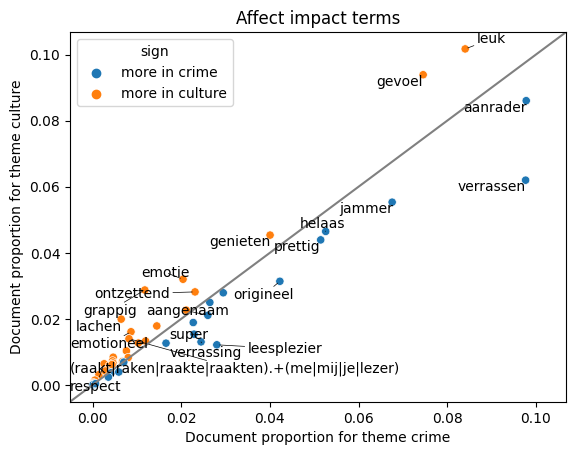

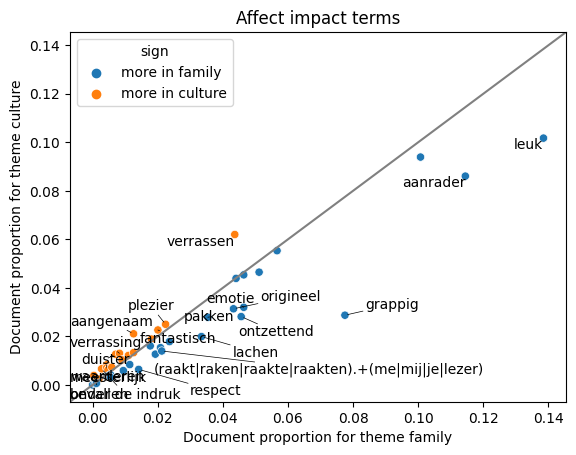

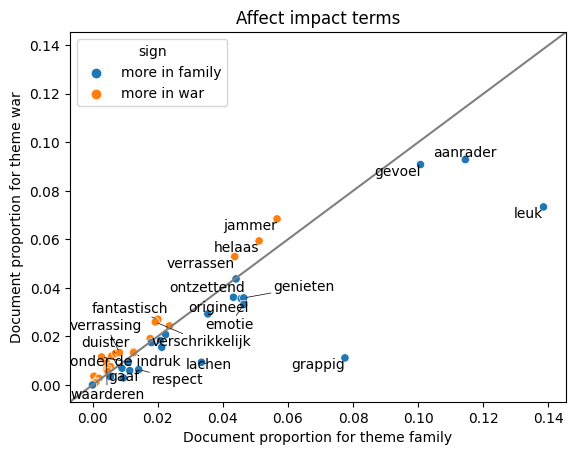

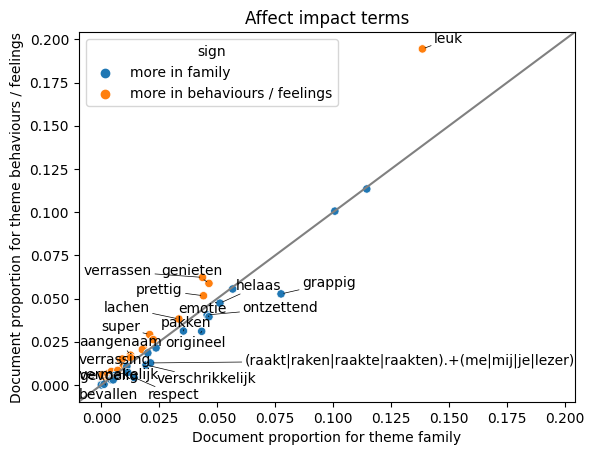

In [73]:
it = 'affect'
theme1 = 'crime'
theme2 = 'culture'

plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

it = 'affect'
theme1 = 'family'
theme2 = 'culture'

plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

it = 'affect'
theme1 = 'family'
theme2 = 'war'

plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

it = 'affect'
theme1 = 'family'
theme2 = 'behaviours / feelings'

plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)


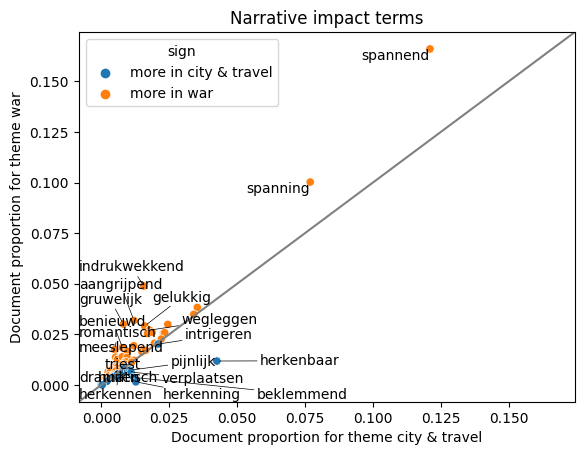

In [75]:
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

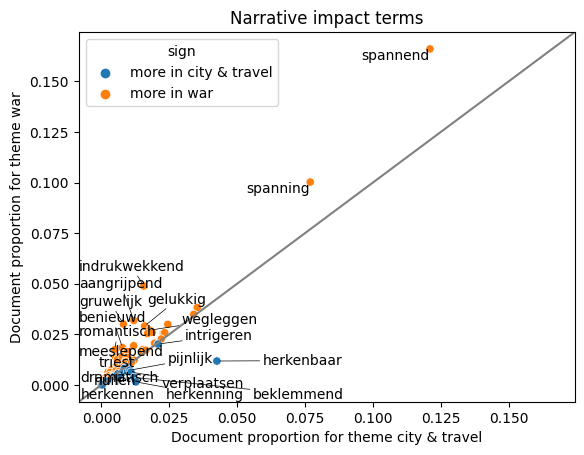

In [76]:
it = 'narrative'
theme1 = 'city & travel'
theme2 = 'war'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)


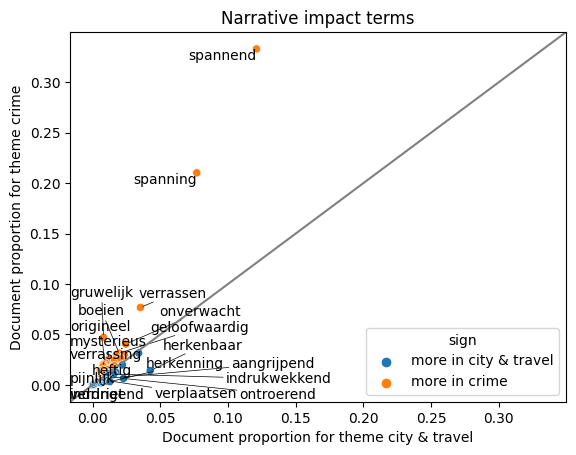

In [77]:
it = 'narrative'
theme1 = 'city & travel'
theme2 = 'crime'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)


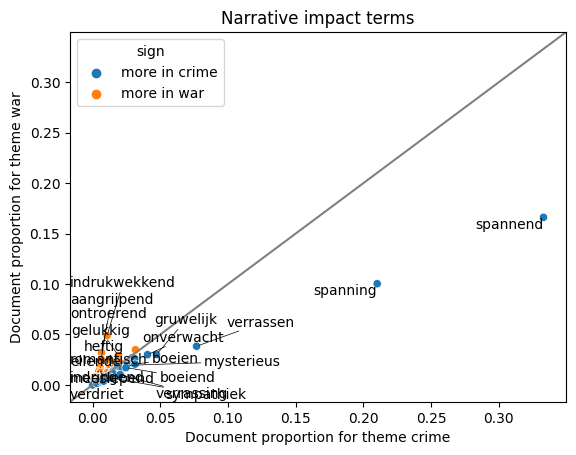

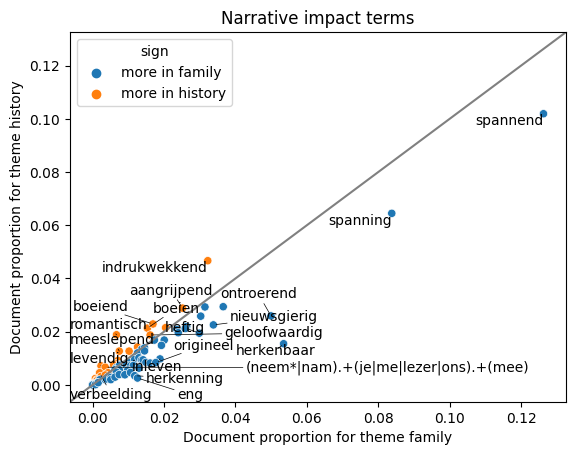

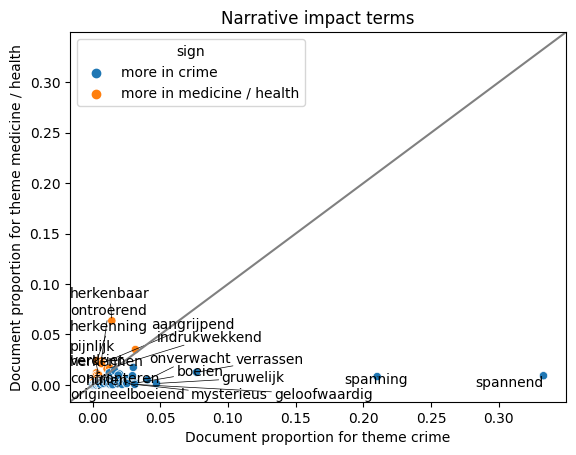

In [86]:
it = 'narrative'
theme1 = 'crime'
theme2 = 'war'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

# it = 'narrative'
# theme1 = 'family'
# theme2 = 'wildlife / nature'
# plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

# it = 'narrative'
# theme1 = 'war'
# theme2 = 'history'
# plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

it = 'narrative'
theme1 = 'family'
theme2 = 'history'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

it = 'narrative'
theme1 = 'crime'
theme2 = 'medicine / health'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)

# it = 'narrative'
# theme1 = 'economy & work'
# theme2 = 'medicine / health'
# plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)


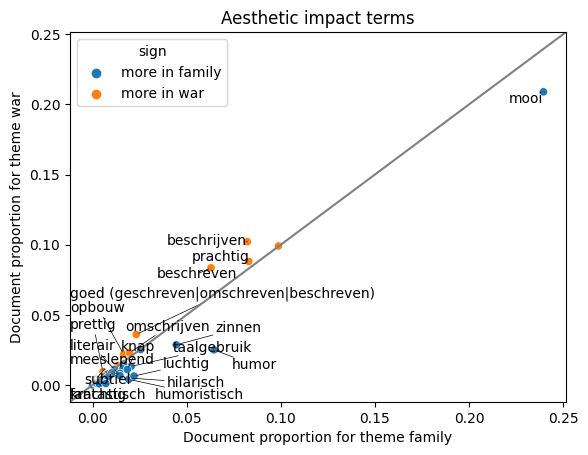

In [81]:
it = 'aesthetic'
theme1 = 'family'
theme2 = 'war'
plot_theme_frac_diff(term_theme_frac, it, theme1, theme2, topn=10, match_scales=True)


## Themes and Review Frequency Distribution

In [196]:
from collections import Counter


def make_cdf(values):
    """Return the cumulative distribution function of a list of values."""
    values = [v for v in values if np.isnan(v) == False]
    total_count = len(values)
    value_count = Counter(values)
    cumu_count = 0
    cdf = []
    for value in sorted(value_count):
        p = (total_count - cumu_count) / total_count
        cdf.append((value, p))
        cumu_count += value_count[value]
    num_reviews, probs = zip(*cdf)
    return pd.DataFrame(data={'num_reviews': num_reviews, 'probs': probs})



In [201]:
work_review_freq = review_stats.work_id.value_counts()
work_review_freq = work_review_freq.rename('work_review_freq').reset_index().rename(columns={'index': 'work_id'})
work_review_freq_theme = (pd.merge(work_review_freq, work_genre_theme, on='work_id', how='right')
                          .fillna(0.0))

work_review_freq_theme = work_review_freq_theme.rename(columns=theme_map)

work_review_freq_theme.head(2)

,work_id,work_review_freq,nur_genre,behaviours / feelings,crime,culture,economy & work,family,geography & setting,history,...,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",travel & transport,war,wildlife / nature
0,impfic-work-6,33.0,Suspense,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,impfic-work-10,2.0,Non-fiction,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [202]:
# compute the cumulative distribution function per theme

theme_cdf = {}
for theme in themes:
    temp_df = work_review_freq_theme[work_review_freq_theme[theme] == 1]
    theme_cdf[theme] = make_cdf(temp_df.work_review_freq)
    theme_cdf[theme]['theme'] = theme

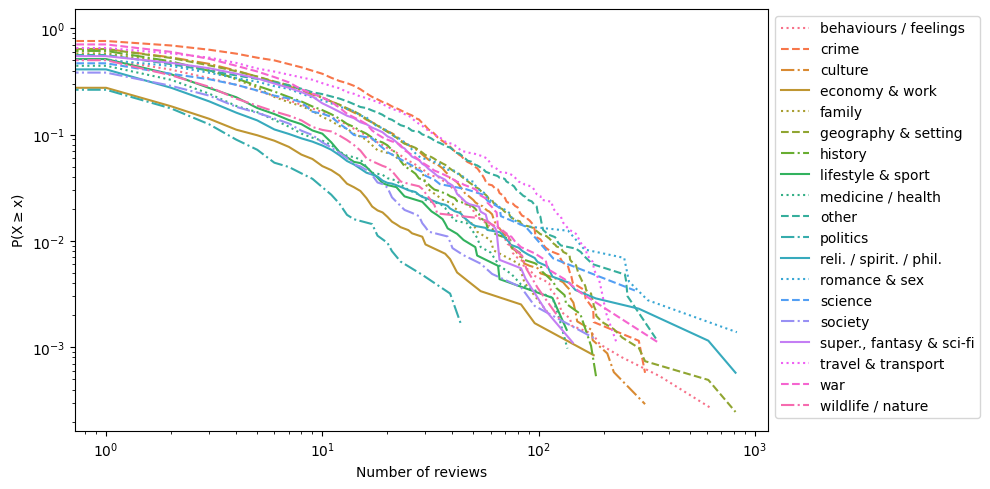

In [224]:
def set_linestyles(ax, lss):
    handles = ax.legend_.legend_handles
    lss_list = lss * int(np.ceil(len(ax.lines) / len(lss)))

    for line, ls, handle in zip(ax.lines, lss_list, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    return None


theme_num_review_prob = pd.concat([theme_cdf[theme] for theme in themes])

ax = sns.lineplot(data=theme_num_review_prob, x='num_reviews', y='probs', hue='theme', hue_order=themes)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('P(X$\geq$x)')

lss = [':', '--', '-.', '-']

set_linestyles(ax, lss)
ax.figure.set_size_inches(10, 5)

handles, labels = ax.get_legend_handles_labels()
# Needed to make sure the linestyles are carried over to the legend
for hi, handle in enumerate(handles):
    lss_idx = hi % len(lss)
    handles[hi].set_linestyle(lss[lss_idx])
    
ax.legend(handles, labels)
ax.legend(bbox_to_anchor=(1.0, 1.0))

ax.figure.tight_layout()
ax.figure.savefig('../images/theme_num_review_cdf.png', dpi=150)

In [226]:
review_theme

,review_id,review_num_words,work_id,nur_genre,themes_behaviours / feelings,themes_crime,themes_culture,themes_economy & work,themes_family,themes_geography & setting,...,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_travel & transport,themes_war,themes_wildlife / nature,log_num_words
0,impfic-review-36736,51,impfic-work-35144,Historical_fiction,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,4.931826
1,impfic-review-36737,587,impfic-work-35144,Historical_fiction,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,7.375025
2,impfic-review-36738,38,impfic-work-35144,Historical_fiction,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,4.637586
3,impfic-review-36739,396,impfic-work-35144,Historical_fiction,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,6.981414
4,impfic-review-36740,131,impfic-work-35144,Historical_fiction,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,5.875197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132140,impfic-review-669404,34,impfic-work-29183,Regional_fiction,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.526361
132141,impfic-review-670825,506,impfic-work-31128,Suspense,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.226537
132142,impfic-review-670891,657,impfic-work-18889,Suspense,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7.487684
132143,impfic-review-670901,662,impfic-work-54096,Literary_fiction,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.495266


## Themes and Impact Type

### Intermezzo: Review length and genre

In [226]:
def resample(sample, resample_length):
    resample_index = np.random.randint(0, len(sample), resample_length)
    return sample[resample_index]


def two_sample_bootstrap_test(sample1, sample2, stat_func, num_samples: int = 100):
    sample1 = np.array(sample1)
    sample2 = np.array(sample2)
    resampled_stats = []
    resampled_signs = []
    for n in range(num_samples):
        resample1 = resample(sample1, len(sample1))
        resample2 = resample(sample2, len(sample2))
        stat = stat_func(resample1) / stat_func(resample2)
        sign = 1 if stat > 1.0 else 0
        resampled_stats.append(stat)
        resampled_signs.append(sign)
    p_value = sum(resampled_signs) / len(resampled_signs)
    return p_value, np.array([resampled_stats, resampled_signs])

genre1 = 'Literary_fiction'
genre2 = 'Literary_thriller'

alpha = 0.05
for genre1, genre2 in permutations(sorted(genres), 2):
    sample1 = review_stats[review_stats.nur_genre == genre1].review_num_words
    sample2 = review_stats[review_stats.nur_genre == genre2].review_num_words
    
    p, stats = two_sample_bootstrap_test(sample1, sample2, np.mean, num_samples=1000)
    sig = True if p < alpha or p > 1 - alpha else False
    print(f"{genre1: <20}\t{genre2: <20}{p: 6.2f}\t{sig}")

Children_fiction    	Fantasy_fiction       0.00	True
Children_fiction    	Historical_fiction    0.00	True
Children_fiction    	Literary_fiction      0.00	True
Children_fiction    	Literary_thriller     0.00	True
Children_fiction    	Non-fiction           1.00	True
Children_fiction    	Other fiction         0.00	True
Children_fiction    	Regional_fiction      0.34	False
Children_fiction    	Romance               0.00	True
Children_fiction    	Suspense              0.00	True
Children_fiction    	Young_adult           0.00	True
Children_fiction    	unknown               1.00	True
Fantasy_fiction     	Children_fiction      1.00	True
Fantasy_fiction     	Historical_fiction    0.04	True
Fantasy_fiction     	Literary_fiction      1.00	True
Fantasy_fiction     	Literary_thriller     1.00	True
Fantasy_fiction     	Non-fiction           1.00	True
Fantasy_fiction     	Other fiction         1.00	True
Fantasy_fiction     	Regional_fiction      1.00	True
Fantasy_fiction     	Romance               1.

In [213]:
review_stats.groupby('nur_genre').log_num_words.describe()

,count,mean,std,min,25%,50%,75%,max
nur_genre,,,,,,,,
Children_fiction,25074.0,4.249549,1.213086,0.0,3.367296,4.127134,5.231109,7.560601
Fantasy_fiction,13101.0,4.528932,1.188320,0.0,3.688879,4.499810,5.480639,7.822845
Historical_fiction,3289.0,4.570410,1.242111,0.0,3.784190,4.682131,5.541264,7.429521
Literary_fiction,193924.0,4.381033,1.258015,0.0,3.555348,4.382027,5.332719,9.019422
Literary_thriller,75729.0,4.437698,1.192911,0.0,3.610918,4.430817,5.389072,8.579417
Non-fiction,95082.0,4.036631,1.086687,0.0,3.332205,3.970292,4.700480,8.631949
Other fiction,34740.0,4.467108,1.206020,0.0,3.610918,4.430817,5.398163,7.963808
Regional_fiction,1374.0,4.338697,1.166090,0.0,3.555348,4.330733,5.225747,6.898715
Romance,6249.0,4.238416,1.563692,0.0,3.295837,4.499810,5.525453,7.221836


<Axes: xlabel='log_num_words', ylabel='nur_genre'>

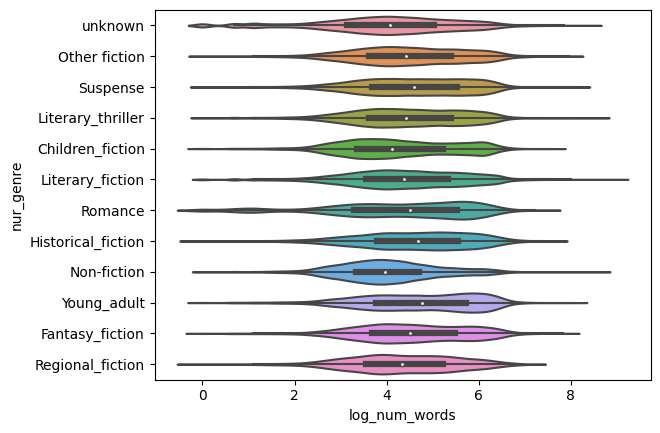

In [218]:
#review_stats[['log_num_words', 'nur_genre']].boxplot(by='nur_genre', rot=45)
#sns.boxplot(data=review_stats, x="log_num_words", y="nur_genre")
sns.violinplot(data=review_stats, x="log_num_words", y="nur_genre")
